In [1]:
import json
import pathlib
import pickle
from typing import List
from typing import Tuple

import pandas
from sklearn import model_selection
from sklearn import neighbors
from sklearn import pipeline
from sklearn import preprocessing

In [2]:
SALES_PATH = "data/kc_house_data.csv"  # path to CSV with home sale data
DEMOGRAPHICS_PATH = "data/kc_house_data.csv"  # path to CSV with demographics
# List of columns (subset) that will be taken from home sale data
SALES_COLUMN_SELECTION = [
    'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
    'sqft_above', 'sqft_basement', 'zipcode'
]
OUTPUT_DIR = "model"  # Directory where output artifacts will be saved

In [4]:
def load_data(
    sales_path: str, demographics_path: str, sales_column_selection: List[str]
) -> Tuple[pandas.DataFrame, pandas.Series]:
    """Load the target and feature data by merging sales and demographics.

    Args:
        sales_path: path to CSV file with home sale data
        demographics_path: path to CSV file with home sale data
        sales_column_selection: list of columns from sales data to be used as
            features

    Returns:
        Tuple containg with two elements: a DataFrame and a Series of the same
        length.  The DataFrame contains features for machine learning, the
        series contains the target variable (home sale price).

    """
    data = pandas.read_csv(sales_path,
                           usecols=sales_column_selection,
                           dtype={'zipcode': str})
    demographics = pandas.read_csv("data/zipcode_demographics.csv",
                                   dtype={'zipcode': str})

    merged_data = data.merge(demographics, how="left",
                             on="zipcode").drop(columns="zipcode")
    data_unfileterd = pandas.read_csv(sales_path, dtype={'zipcode': str})
    # data_unfileterd = data.merge(demographics, how="left",
    #                             on="zipcode").drop(columns="zipcode")
    
    # Remove the target variable from the dataframe, features will remain
    y = merged_data.pop('price')
    x = merged_data

    return x, y, data_unfileterd

In [5]:
x, y, data_unfiltered = load_data(SALES_PATH, DEMOGRAPHICS_PATH, SALES_COLUMN_SELECTION)

In [29]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21613 entries, 0 to 21612
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   bedrooms                21613 non-null  int64  
 1   bathrooms               21613 non-null  float64
 2   sqft_living             21613 non-null  int64  
 3   sqft_lot                21613 non-null  int64  
 4   floors                  21613 non-null  float64
 5   sqft_above              21613 non-null  int64  
 6   sqft_basement           21613 non-null  int64  
 7   ppltn_qty               21613 non-null  float64
 8   urbn_ppltn_qty          21613 non-null  float64
 9   sbrbn_ppltn_qty         21613 non-null  float64
 10  farm_ppltn_qty          21613 non-null  float64
 11  non_farm_qty            21613 non-null  float64
 12  medn_hshld_incm_amt     21613 non-null  float64
 13  medn_incm_per_prsn_amt  21613 non-null  float64
 14  hous_val_amt            21613 non-null

In [30]:
x.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,ppltn_qty,urbn_ppltn_qty,sbrbn_ppltn_qty,...,per_sbrbn,per_farm,per_non_farm,per_less_than_9,per_9_to_12,per_hsd,per_some_clg,per_assoc,per_bchlr,per_prfsnl
count,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,...,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,1788.390691,291.509045,28980.783001,28008.304400,147.210290,...,1.703188,0.049137,4.622542,1.836996,5.077638,14.394392,18.678295,5.131634,19.413640,8.838754
std,0.930062,0.770163,918.440897,4.142051e+04,0.539989,828.090978,442.575043,10926.187336,11858.536684,1153.766217,...,10.842697,0.275455,13.241714,2.156718,2.475250,4.437998,2.789687,0.780764,7.048811,5.094015
min,0.000000,0.000000,290.000000,5.200000e+02,1.000000,290.000000,0.000000,3037.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,11.000000,2.000000,6.000000,2.000000
25%,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,1190.000000,0.000000,22269.000000,20815.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,3.000000,11.000000,17.000000,5.000000,13.000000,4.000000
50%,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,0.000000,26819.000000,25593.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,5.000000,15.000000,19.000000,5.000000,19.000000,7.500000
75%,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,2210.000000,560.000000,37695.000000,35624.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,7.000000,17.000000,20.000000,6.000000,25.000000,12.000000
max,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,4820.000000,64181.000000,64181.000000,11176.000000,...,81.000000,2.000000,98.000000,11.000000,11.000000,25.000000,34.000000,7.000000,39.000000,24.000000


In [31]:
data_unfiltered.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [32]:
# Missing cols - Geo data? We could use a geohash to encode the lat/long - Cat2vec embedding
[col for col in data_unfiltered.columns if col not in x.columns]

['id',
 'date',
 'price',
 'waterfront',
 'view',
 'condition',
 'grade',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [9]:
print("condition", data_unfiltered['condition'].unique())
print("waterfront", data_unfiltered['waterfront'].unique())
print("view", data_unfiltered['view'].unique())
print("grade", data_unfiltered['grade'].unique())
print('yr_built', data_unfiltered[ 'yr_built'].unique())
print('yr_renovated', data_unfiltered[ 'yr_renovated'].unique())



condition [3 5 4 1 2]
waterfront [0 1]
view [0 3 4 2 1]
grade [ 7  6  8 11  9  5 10 12  4  3 13  1]
yr_built [1955 1951 1933 1965 1987 2001 1995 1963 1960 2003 1942 1927 1977 1900
 1979 1994 1916 1921 1969 1947 1968 1985 1941 1915 1909 1948 2005 1929
 1981 1930 1904 1996 2000 1984 2014 1922 1959 1966 1953 1950 2008 1991
 1954 1973 1925 1989 1972 1986 1956 2002 1992 1964 1952 1961 2006 1988
 1962 1939 1946 1967 1975 1980 1910 1983 1978 1905 1971 2010 1945 1924
 1990 1914 1926 2004 1923 2007 1976 1949 1999 1901 1993 1920 1997 1943
 1957 1940 1918 1928 1974 1911 1936 1937 1982 1908 1931 1998 1913 2013
 1907 1958 2012 1912 2011 1917 1932 1944 1902 2009 1903 1970 2015 1934
 1938 1919 1906 1935]
yr_renovated [   0 1991 2002 2010 1999 1992 2013 1994 1978 2005 2008 2003 1984 1954
 2014 2011 1974 1983 1945 1990 1988 1957 1977 1981 1995 2000 1998 1970
 1989 2004 1986 2009 2007 1987 1973 2006 1985 2001 1980 1971 1979 1997
 1950 1969 1948 2015 1968 2012 1963 1951 1993 1962 1996 1972 1953 1955
 198

In [44]:
# corr between price and condition, waterfront, view, grade

data_unfiltered[['price', 'condition']].corr()

data_unfiltered[['price', 'waterfront']].corr()

data_unfiltered[['price', 'view']].corr()

data_unfiltered[['price', 'grade']].corr()


,price,grade
price,1.000000,0.667434
grade,0.667434,1.000000


<AxesSubplot: >

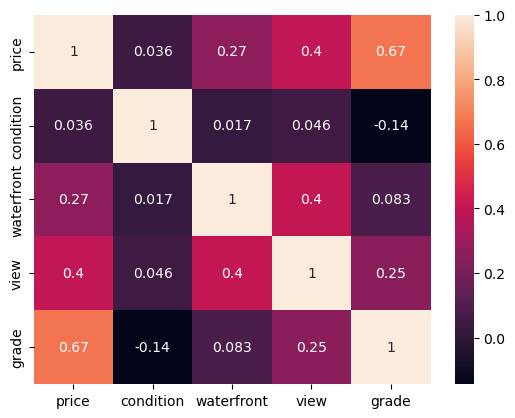

In [45]:
import seaborn as sns

sns.heatmap(data_unfiltered[['price', 'condition', 'waterfront', 'view', 'grade']].corr(), annot=True)

In [35]:
import pygeohash as pgh

# encode lat/long

data_unfiltered['geohash'] = data_unfiltered.apply(lambda x: pgh.encode(x['lat'], x['long'], precision=10), axis=1)
data_unfiltered['geohash'].nunique()



20832

In [37]:
# load pipeline model from /model/model.pkl and the model feautures from model/model_features.json
import joblib
import json


model = joblib.load("model/model.pkl")
model_features = json.load(open("model/model_features.json", "r"))
predictions = model.predict(x[model_features])





/Users/emelillan/opt/anaconda3/envs/datascience/lib/python3.10/site-packages/threadpoolctl.py:1223: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [38]:
# eval regression model with rmse mae and r2

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = mean_squared_error(y, predictions, squared=False)
mae = mean_absolute_error(y, predictions)
r2 = r2_score(y, predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")


RMSE: 160017.47981660964
MAE: 82689.78274186833
R2: 0.8100138984242224


# Model version 2

In [12]:
import xgboost as xgb

In [53]:
new_cols = [
'condition',
'waterfront',
'view',
'grade',
'yr_built',
'yr_renovated'
]

final_cols = SALES_COLUMN_SELECTION + new_cols

In [54]:
x, y, data_unfiltered = load_data(SALES_PATH, DEMOGRAPHICS_PATH, SALES_COLUMN_SELECTION + new_cols)

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

In [63]:

def create_pipeline():
    """Creates a pipeline with RobustScaler and XGBRegressor."""
    scaler = RobustScaler()
    model = XGBRegressor()
    pipeline = Pipeline(steps=[("scaler", scaler), ("model", model)])
    return pipeline


def train_test_split_data(X, y, test_size=0.2, random_state=42):
    """Splits data into training and testing sets."""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    return X_train, X_test, y_train, y_test


def random_search(X_train, y_train, param_dist, n_iter=15, cv=5):
    """Performs a randomized search for hyperparameter tuning."""
    pipeline = create_pipeline()
    random_search = RandomizedSearchCV(
        pipeline, param_distributions=param_dist, n_iter=n_iter, cv=cv
    )
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_, random_search.best_params_


# Example usage:
# Assuming you have your data in X and y variables
X_train, X_test, y_train, y_test = train_test_split_data(x, y)

# Define your parameter distribution for randomized search
param_dist = {
    "model__learning_rate": [0.01, 0.1, 0.3],
    "model__n_estimators": [100, 300, 500],
    "model__max_depth": [3, 5, 7],
    "model__colsample_bytree": [0.3, 0.7, 1.0],
    "model__subsample": [0.2, 0.5, 0.8],
    "model__gamma": [0, 1, 5],
    "model__reg_alpha": [0, 1, 5],
    "model__reg_lambda": [0, 1, 5],
}

# Perform randomized search and get best model and parameters
best_model, best_params = random_search(X_train, y_train, param_dist)

# Use the best model for prediction on test data
predictions = best_model.predict(X_test)

# Evaluate model performance on test data (e.g., using metrics like RMSE)

In [64]:
# eval the model with the train data

predictions = best_model.predict(X_train)

rmse = mean_squared_error(y_train, predictions, squared=False)
mae = mean_absolute_error(y_train, predictions)
r2 = r2_score(y_train, predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")


RMSE: 88021.700481922
MAE: 59431.83235567886
R2: 0.9406972677841379


In [71]:
# eval regression model in test data
predictions = best_model.predict(X_test)

rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")


RMSE: 137921.25453831747
MAE: 74168.16855518447
R2: 0.8741719397819447


sklearn.pipeline.Pipeline